In [1]:
# importing libraries 
import pandas as pd 
import numpy as np 
import torch
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import matplotlib.pyplot as plt 

In [2]:
model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/Users/nikhilkudupudi/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device 

'mps'

## EDA With the dataset!!

In [2]:
df= pd.read_csv('articles.csv')
df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [3]:
df.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [4]:
remove_cols=['product_code','product_type_no','graphical_appearance_no','colour_group_code','index_code',
             'index_group_no','section_no','garment_group_no','perceived_colour_value_id',
             'perceived_colour_master_id','department_no']
df=df.drop(remove_cols,axis=1)

df['article_id'] = df['article_id'].astype(str)
df['article_id']=["0"+x for x in df['article_id']]

In [5]:
df.columns

Index(['article_id', 'prod_name', 'product_type_name', 'product_group_name',
       'graphical_appearance_name', 'colour_group_name',
       'perceived_colour_value_name', 'perceived_colour_master_name',
       'department_name', 'index_name', 'index_group_name', 'section_name',
       'garment_group_name', 'detail_desc'],
      dtype='object')

In [6]:
df

,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc
0,0108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,0953450001,5pk regular Placement1,Socks,Socks & Tights,Placement print,Black,Dark,Black,Socks Bin,Menswear,Menswear,Men Underwear,Socks and Tights,Socks in a fine-knit cotton blend with a small...
105538,0953763001,SPORT Malaga tank,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey,Ladieswear,Ladieswear,H&M+,Jersey Fancy,Loose-fitting sports vest top in ribbed fast-d...
105539,0956217002,Cartwheel dress,Dress,Garment Full body,Solid,Black,Dark,Black,Jersey,Ladieswear,Ladieswear,Womens Trend,Jersey Fancy,"Short, A-line dress in jersey with a round nec..."
105540,0957375001,CLAIRE HAIR CLAW,Hair clip,Accessories,Solid,Black,Dark,Black,Small Accessories,Divided,Divided,Divided Accessories,Accessories,Large plastic hair claw.


In [7]:
product_groups_list=['Garment Upper body','Garment Lower body','Garment Full body','Socks and Tights','Nightwear','Shoes','Swimwear','Unknown']
selected_articles = articles.loc[articles['product_group_name'].isin(product_groups_list)].reset_index()

NameError: name 'articles' is not defined

In [8]:
product_groups_list=['Garment Upper body','Garment Lower body','Garment Full body','Socks and Tights','Nightwear','Shoes','Swimwear','Unknown']
df = df.loc[df['product_group_name'].isin(product_groups_list)].reset_index()

df

,index,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc
0,0,0108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
1,1,0108775044,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
2,2,0108775051,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
3,8,0111586001,Shape Up 30 den 1p Tights,Leggings/Tights,Garment Lower body,Solid,Black,Dark,Black,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,Tights with built-in support to lift the botto...
4,11,0112679048,SWEATSHIRT OC,Sweater,Garment Upper body,All over pattern,Grey,Dusty Light,Grey,Baby basics,Baby Sizes 50-98,Baby/Children,Baby Essentials & Complements,Jersey Basic,Sweatshirt in soft organic cotton with a pres...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86270,105535,0952937003,Jets dress,Dress,Garment Full body,All over pattern,Beige,Medium Dusty,Mole,Jersey,Ladieswear,Ladieswear,Womens Trend,Jersey Fancy,"Fitted, calf-length dress in viscose jersey wi..."
86271,105536,0952938001,Elton top,Top,Garment Upper body,All over pattern,Beige,Medium Dusty,Mole,Jersey,Ladieswear,Ladieswear,Womens Trend,Jersey Fancy,Fitted top in jersey with a round neckline and...
86272,105538,0953763001,SPORT Malaga tank,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey,Ladieswear,Ladieswear,H&M+,Jersey Fancy,Loose-fitting sports vest top in ribbed fast-d...
86273,105539,0956217002,Cartwheel dress,Dress,Garment Full body,Solid,Black,Dark,Black,Jersey,Ladieswear,Ladieswear,Womens Trend,Jersey Fancy,"Short, A-line dress in jersey with a round nec..."


In [9]:
df.loc[(df['product_group_name'] == 'Unknown') & (df['department_name']=='Ladies Sport Bras'),'detail_desc'][66105]

'Wide sports top in fast-drying functional fabric with a slightly wider neckline and short cap sleeves. Rounded and slightly longer at the back.'

In [72]:
pd.DataFrame(df[['product_type_name','prod_name','detail_desc']].value_counts()).or
# .to_csv('prod_names.csv')

# Taking a Sample dataset to check #

In [48]:
df.columns

Index(['index', 'article_id', 'prod_name', 'product_type_name',
       'product_group_name', 'graphical_appearance_name', 'colour_group_name',
       'perceived_colour_value_name', 'perceived_colour_master_name',
       'department_name', 'index_name', 'index_group_name', 'section_name',
       'garment_group_name', 'detail_desc'],
      dtype='object')

In [11]:
df.head()

,index,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc
0,0,0108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
1,1,0108775044,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
2,2,0108775051,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
3,8,0111586001,Shape Up 30 den 1p Tights,Leggings/Tights,Garment Lower body,Solid,Black,Dark,Black,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,Tights with built-in support to lift the botto...
4,11,0112679048,SWEATSHIRT OC,Sweater,Garment Upper body,All over pattern,Grey,Dusty Light,Grey,Baby basics,Baby Sizes 50-98,Baby/Children,Baby Essentials & Complements,Jersey Basic,Sweatshirt in soft organic cotton with a pres...


In [50]:
rem_col =['index','perceived_colour_value_name','perceived_colour_master_name','index_name','department_name','section_name', 'index_group_name','garment_group_name']
df2 = df.drop(rem_col, axis=1)
df2.head()

,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,detail_desc
0,0108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Jersey top with narrow shoulder straps.
1,0108775044,Strap top,Vest top,Garment Upper body,Solid,White,Jersey top with narrow shoulder straps.
2,0108775051,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Jersey top with narrow shoulder straps.
3,0111586001,Shape Up 30 den 1p Tights,Leggings/Tights,Garment Lower body,Solid,Black,Tights with built-in support to lift the botto...
4,0112679048,SWEATSHIRT OC,Sweater,Garment Upper body,All over pattern,Grey,Sweatshirt in soft organic cotton with a pres...


In [56]:
df2.tail()

,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,detail_desc
86270,0952937003,Jets dress,Dress,Garment Full body,All over pattern,Beige,"Fitted, calf-length dress in viscose jersey wi..."
86271,0952938001,Elton top,Top,Garment Upper body,All over pattern,Beige,Fitted top in jersey with a round neckline and...
86272,0953763001,SPORT Malaga tank,Vest top,Garment Upper body,Solid,Black,Loose-fitting sports vest top in ribbed fast-d...
86273,0956217002,Cartwheel dress,Dress,Garment Full body,Solid,Black,"Short, A-line dress in jersey with a round nec..."
86274,0959461001,Lounge dress,Dress,Garment Full body,Solid,Off White,Calf-length dress in ribbed jersey made from a...


In [68]:
pd.DataFrame(df2['prod_name'].value_counts()).to_csv('prod_names.csv')

In [63]:
df['detail_desc'][86272]

'Loose-fitting sports vest top in ribbed fast-drying functional fabric made from recycled polyester with a racer back and rounded hem.'

In [64]:
df['prod_name'][86272]

'SPORT Malaga tank'

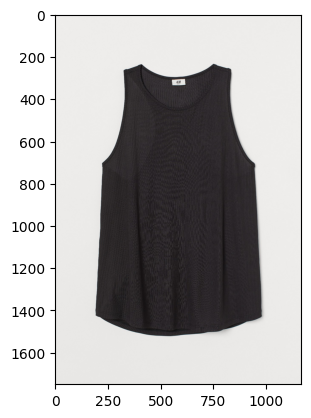

In [65]:
img_path = df['article_id'][86272]
folder = img_path[0:3]
path_to_img = '/Users/nikhilkudupudi/Projects - School & Work/Capstone/images/' + folder +'/'+ img_path +'.jpg'
with Image.open(path_to_img) as img:
    plt.imshow(img)

## Text and Image Embedding

In [12]:
import os
from PIL import Image
import numpy as np
import os

In [14]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

model_ID = "openai/clip-vit-base-patch32"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

/Users/nikhilkudupudi/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [33]:
def text_embed(txt :str):
    inputs = tokenizer(text, return_tensors = "pt")
	text_embeddings = model.get_text_features(**inputs)

    return text_embeddings.cpu().detach().numpy()

def load_images(img: str):
    folder = img[0:3]
    path_to_img = '/Users/nikhilkudupudi/Projects - School & Work/Capstone/images/' + folder +'/'+ img+'.jpg'
    
    with Image.open(path_to_img) as img:
        image = processor(text = None,images = img,return_tensors="pt")["pixel_values"].to(device)

    embedding = model.get_image_features(image)	

    return embedding.cpu().detach().numpy()


In [24]:
df['article_id'][0]

'0108775015'

In [34]:
im = load_images('0108775015')
print(type(im))

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
